# Multimodal human bone marrow data

Here, you will be guided through preprocessing and multimodal analysis of human bone marrow data.

Data comes from [Mimitou, Eleni P., et al. "Scalable, multimodal profiling of chromatin accessibility, gene expression and protein levels in single cells." Nature biotechnology 39.10 (2021): 1246-1258.](https://www.nature.com/articles/s41587-021-00927-2) and consists of two single-cell modalities: proteins and chromatin. All analyses are performed on prefiltered data published by the authors on [GitHub](https://github.com/caleblareau/asap_reproducibility/tree/master/bonemarow_asapseq/output/for_total_vi_asap_marrow/filtered_feature_bc_matrix).

## Load the data

After downloading the data, steps required for its loading are hugely dependent on the format. In this case, the count matrix is a .mtx file, which we can load using scanpy.

In [1]:
import scanpy as scp
from os.path import join

data_folder = 'data/human-bone-marrow'

m = scp.read_mtx(join(data_folder, 'matrix.mtx'))

The loaded object is an annotated data type called anndata.AnnData. You can read more about this data type [here](https://anndata.readthedocs.io/en/latest/). It is the default data structure for Ocelli and other single-cell packages such as scanpy or scvelo. 

The count matrix needs to be reoriented so that rows and columns correspond to cells and features respectively. Ocelli strictly needs this array orientation.

In [2]:
m = m.transpose()

Next, we annotate cells and features.

In [3]:
import pandas as pd

m.var = pd.read_csv(join(data_folder, 'features.tsv'), sep='\t', header=None)[[1, 2]]
m.var.columns = ['name', 'modality']
m.obs = pd.read_csv(join(data_folder, 'barcodes.tsv'), sep='\t', header=None)
m.obs.columns = ['barcode']

At the end we have a fully-loaded AnnData.

In [4]:
m

AnnData object with n_obs × n_vars = 10927 × 3238
    obs: 'barcode'
    var: 'name', 'modality'

## Preprocess the data

Load Ocelli.

In [5]:
import ocelli as oci

Set a seed for result reproducibility.

In [6]:
SEED = 17

We recommend preprocessing each modality seperately. Then, we will combine preprocessed modalities into a new AnnData storing data ready for analysis.

The loaded count matrix is a concatenated matrix of protein and chromatin count matrices. Therefore, we split it into seperate AnnData objects that will be preprocessed individually.

In [7]:
protein = m[:, m.var['modality'] == 'Antibody Capture']
chromatin = m[:, m.var['modality'] == 'Gene Expression']

The key step of preprocessing that we use is Latent Dirichlet Allocation - a generative probabilistic topic modeling model, which groups data features into cohesive groups (topics). One of its outputs is a distribution of how probable it is that a cell belongs to a topic. We interpret these latent representations as highly-compressed and information-rich data embeddings on which we train models.

In [8]:
oci.pp.LDA(protein, n_components=15, verbose=1, max_iter=50, random_state=SEED)
oci.pp.LDA(chromatin, n_components=15, verbose=1, max_iter=50, random_state=SEED)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

LDA outputs need no further normalization, as they are cell-normalized by design. As a result, we can create a new AnnData for storing all preprocessed modalities. The Ocelli convention is to save modality arrays to AnnData.obsm. AnnData.obsm is basically a dictionary and you need to assign names (keys) to modalities.

In [9]:
import numpy as np
from scipy.sparse import csr_matrix
import anndata

adata = anndata.AnnData(csr_matrix(np.zeros(m.shape)))
adata.obs = m.obs

adata.obsm['chromatin'] = chromatin.obsm['lda']
adata.obsm['protein'] = protein.obsm['lda']

Ocelli during analyses needs to know which AnnData.obsm elements are modality matrices. Therefore, you must clarify it by listing them (literally, as a Python list) under AnnData.uns['views'].

In [10]:
adata.uns['views'] = ['chromatin', 'protein']

Preprocessing and preparation of the data for analyses is finished as soon as we create the AnnData with preprocessed modality arrays and specify view keys.

## Calculate Multimodal Diffusion Maps components

Finally, we start analyzing the data. To visualize it, we must create a multimodal embedding that combines information from both modalities and is greater than the sum of its parts. Ocelli includes the Multimodal Diffusion Maps algorithm that is suitable for this task. 

Firstly, we need to estimate cell-specific multimodal weights. They quantify the contribution of each modality to capturing information about the development of cell's neighborhood. Smaller neighborhood results in local weights, while larger one captures more global information.

In [11]:
oci.pp.neighbors(adata, n_neighbors=50, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)

50 nearest neighbors calculated.


2022-09-22 01:14:22,547	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal cell-specific weights estimated.


Weights are then used to calculate a multimodal Markov chain that is then eigendecomposed. Resulting multimodal diffusion maps components are a multimodal representation of the data. More components result in more complex embedding, however, it is not recommended to use a lot  of components (purposely, we do not specify how much is a lot - it depends on the complexity of the data), as the quality of components decays.

For this dataset, 10 components are sufficient to capture well the global structure.

In [12]:
oci.tl.MDM(adata, n_components=10, random_state=SEED, verbose=True)

Unimodal Markov chain calculated (1/2)
Unimodal Markov chain calculated (2/2)
Multimodal Markov chain calculated
Eigendecomposition finished.
10 multi-view diffusion maps components calculated.


## Visualize the data

In [13]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

Ocelli has wrappers for two tools suitable for further dimensien reduction to 2 or 3 dimensions that can be visualized: ForceAtlas2 and UMAP. ForceAtlas2 is very potent for datasets that form a single cluster with complex substructures, while UMAP works better for data with distinguishable clusters. Therefore, here will use UMAP.

(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

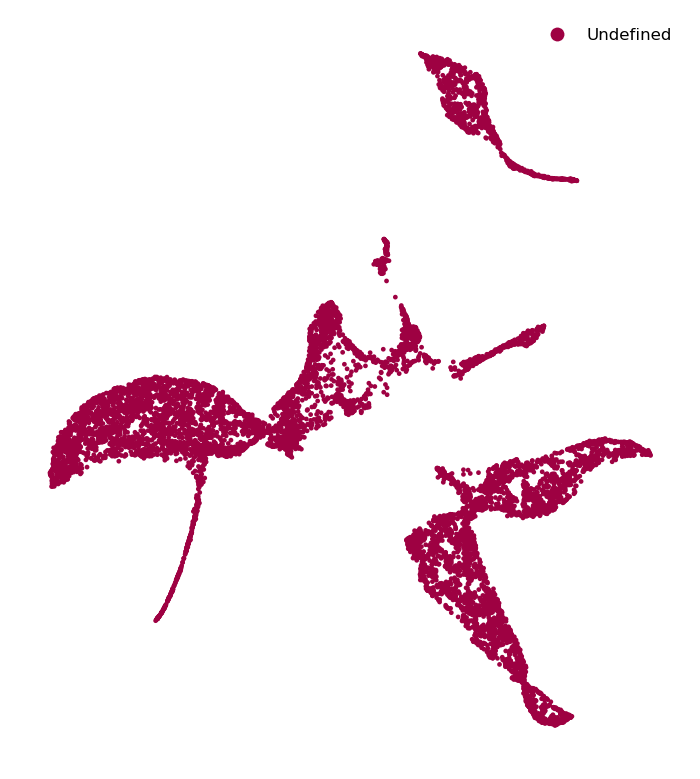

In [14]:
oci.tl.UMAP(adata, obsm_key='X_mdm', n_neighbors=100, min_dist=0.1, random_state=SEED)
oci.pl.scatter(adata, x_key='X_umap', marker_size=0.5)

You can easily change colormaps - using matplotlib colormap objects or [predefined colormap names](https://matplotlib.org/stable/tutorials/colors/colormaps.html) - and color schemes - using aby AnnData.obs columns.

Here, we examine the distributions of learned multimodal weights for both modalities.

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

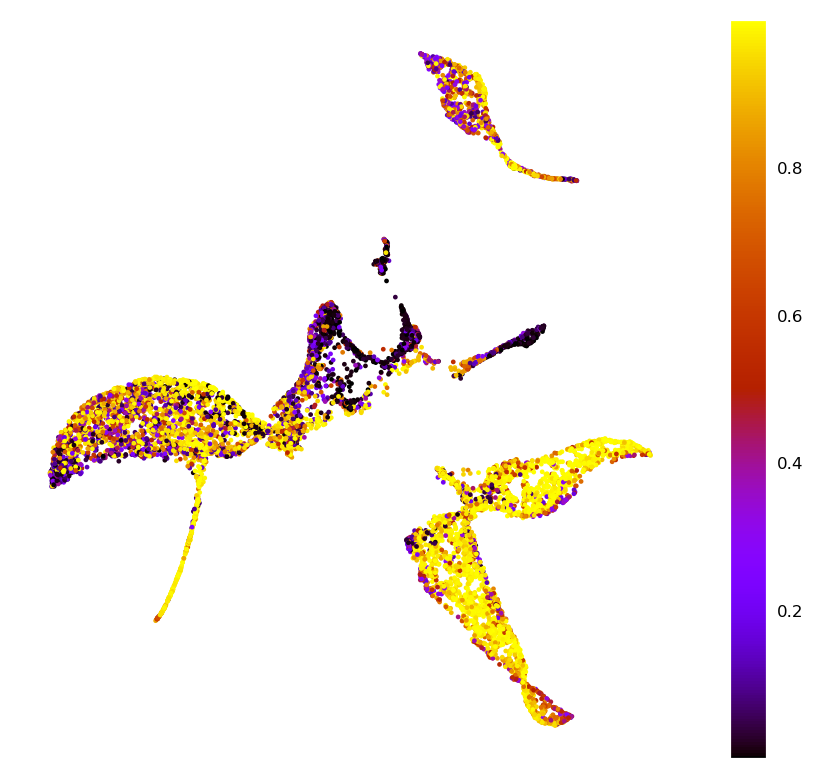

In [15]:
adata.obs['w_protein'] = list(adata.obsm['weights']['protein'])
oci.pl.scatter(adata, x_key='X_umap', color_key='w_protein', cmap='gnuplot', marker_size=0.5)

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

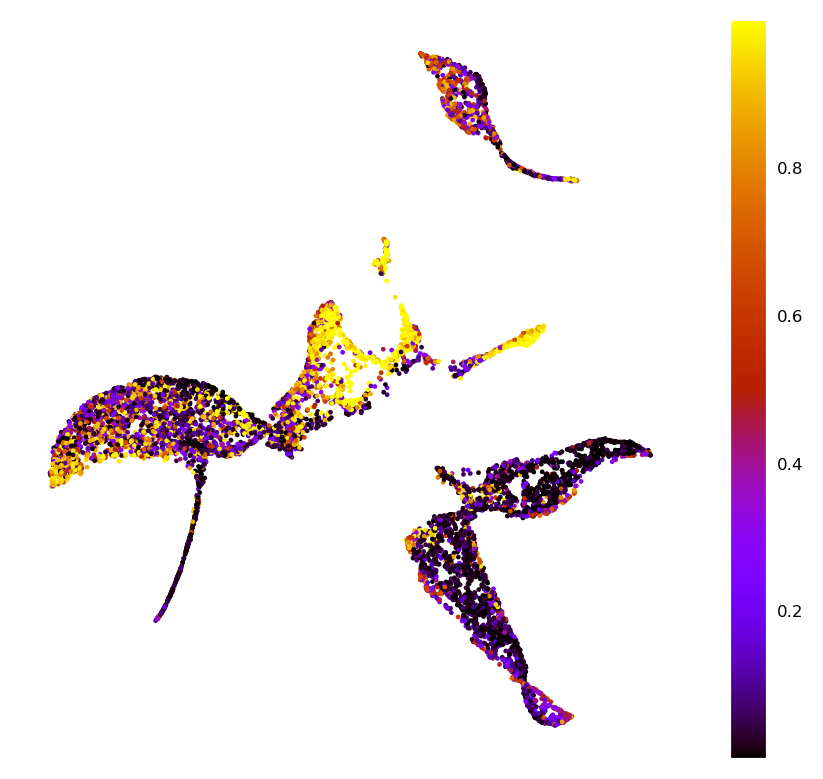

In [16]:
adata.obs['w_chromatin'] = list(adata.obsm['weights']['chromatin'])
oci.pl.scatter(adata, x_key='X_umap', color_key='w_chromatin', cmap='gnuplot', marker_size=0.5)

## Examine marker activity

Maker analysis allows to define cell types. Below you will see how easily you can analyze marker activity using Ocelli. To do so, we need to go back to raw count matrices, normalize and logarithmize them. Such preprocessed counts can be used for calculating z-scores for each cell with respect to given feature. Z-scores will be averaged over specified features, however, here we show z-scores calculated for single protein markers.

In [17]:
import scvelo as scv

scv.pp.normalize_per_cell(protein, counts_per_cell_after=10000)
scv.pp.log1p(protein)

Normalized count data: X.


CD14 protein marker is expressed in monocytes.

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

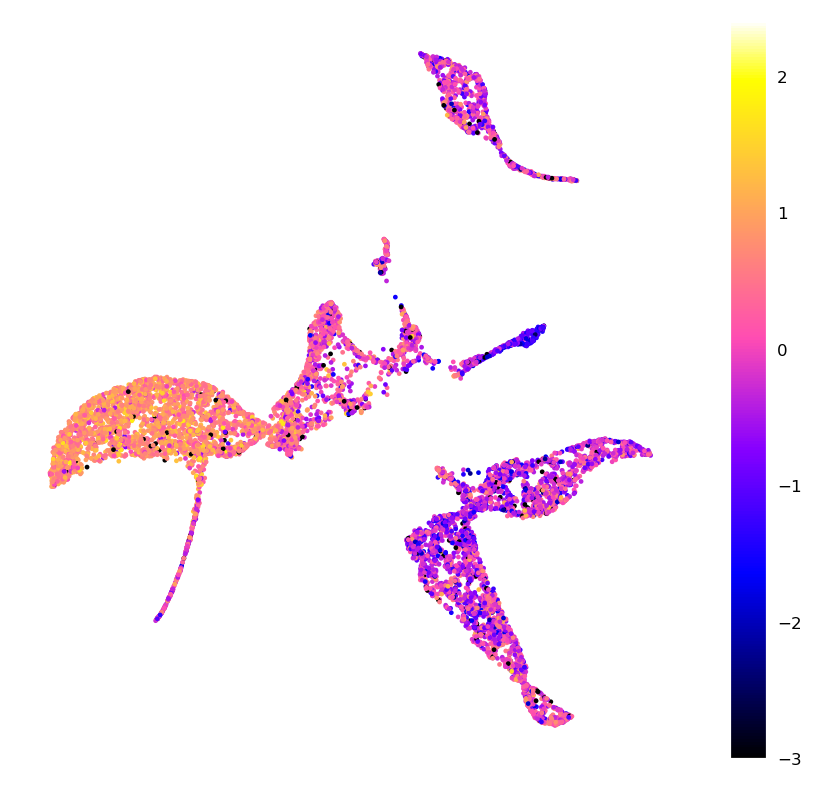

In [18]:
protein_marker =  'CD14'
index_of_marker_column = list(protein.var['name']).index(protein_marker)
oci.tl.mean_z_scores(protein, markers=[index_of_marker_column], output_key=protein_marker)
adata.obs[protein_marker] = list(protein.obs[protein_marker])
oci.pl.scatter(adata, x_key='X_umap', color_key=protein_marker, cmap='gnuplot2', marker_size=0.5)

CD71 protein marker is expressed in progenitor and erythroid cells.

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

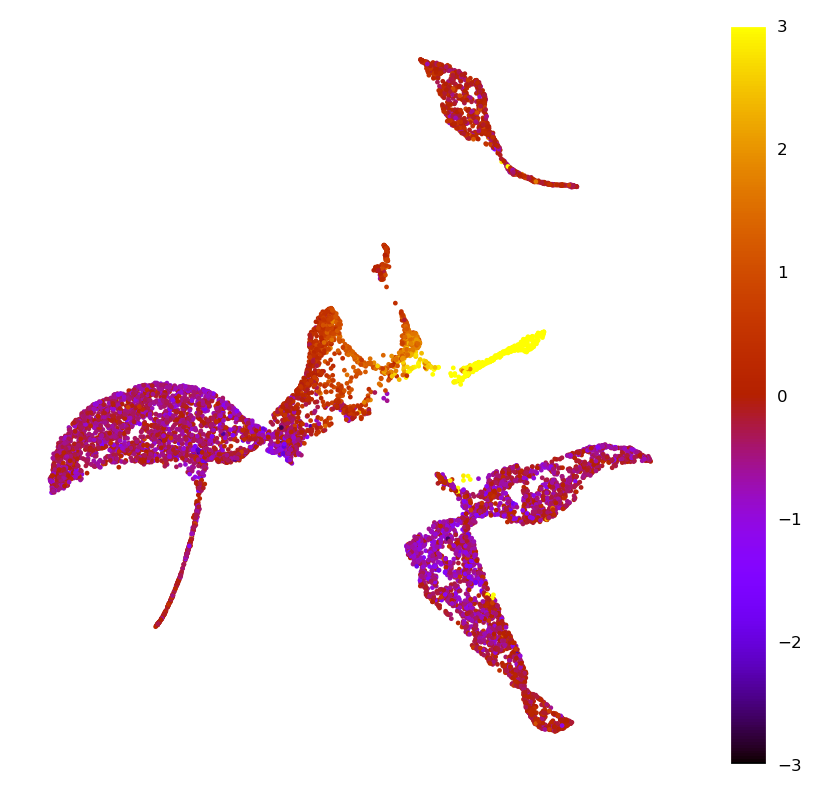

In [19]:
protein_marker =  'CD71'
index_of_marker_column = list(protein.var['name']).index(protein_marker)
oci.tl.mean_z_scores(protein, markers=[index_of_marker_column], output_key=protein_marker)
adata.obs[protein_marker] = list(protein.obs[protein_marker])
oci.pl.scatter(adata, x_key='X_umap', color_key=protein_marker, cmap='gnuplot', marker_size=0.5)

CD71 protein marker is expressed in B cells.

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

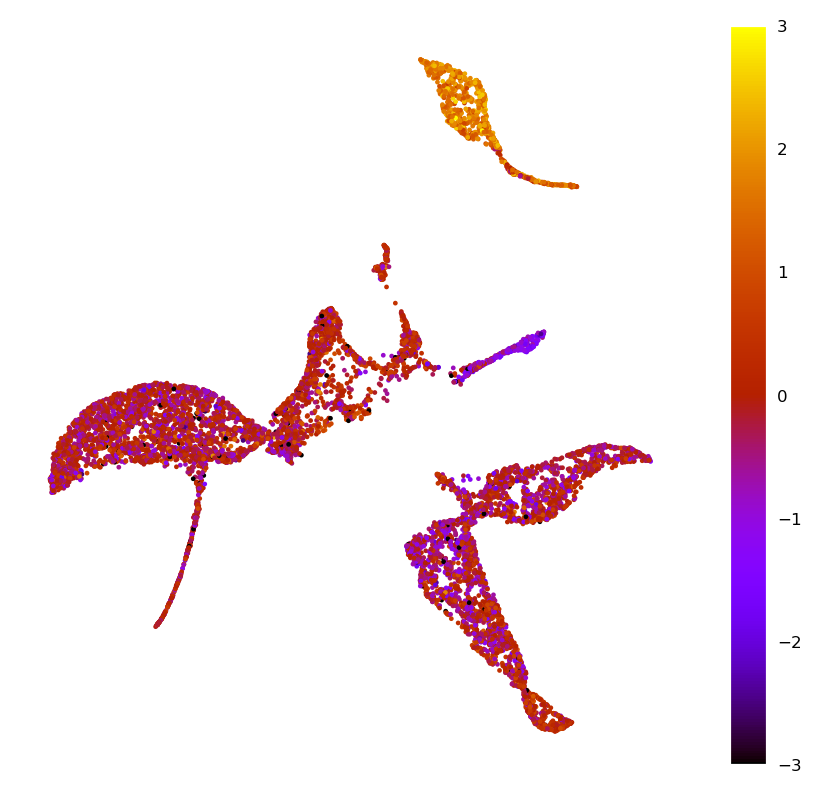

In [20]:
protein_marker =  'CD19'
index_of_marker_column = list(protein.var['name']).index(protein_marker)
oci.tl.mean_z_scores(protein, markers=[index_of_marker_column], output_key=protein_marker)
adata.obs[protein_marker] = list(protein.obs[protein_marker])
oci.pl.scatter(adata, x_key='X_umap', color_key=protein_marker, cmap='gnuplot', marker_size=0.5)